# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

>This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 1, 2012 to current. The dataset can be used to analyze total spirits sales in Iowa of individual products at the store level.
>
>Class E liquor license, for grocery stores, liquor stores, convenience stores, etc., allows commercial establishments to sell liquor for off-premises consumption in original unopened containers.

> ## Scenario 2: Market research for new store locations

>A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

>Goal for Scenario #2: Your task is to:
>
>* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
>* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
>* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
>* Bonus: Recommend targets for volume sold and price per bottle!

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing, metrics
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Load the data into a DataFrame
filepath = "/Users/Nathan/Desktop/Iowa_Liquor_Sales_reduced.csv"
raw_data = pd.read_csv(filepath, low_memory = False)

In [3]:
# Copy the data to maintain an original version
data = raw_data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709552 entries, 0 to 2709551
Data columns (total 18 columns):
Date                     object
Store Number             int64
City                     object
Zip Code                 object
County Number            float64
County                   object
Category                 float64
Category Name            object
Vendor Number            int64
Item Number              int64
Item Description         object
Bottle Volume (ml)       int64
State Bottle Cost        object
State Bottle Retail      object
Bottles Sold             int64
Sale (Dollars)           object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtypes: float64(4), int64(5), object(9)
memory usage: 372.1+ MB


In [5]:
# Make a reduced version of the cleaned data, for faster analysis
#data = data.ix[list(data[['Store Number']].sample(frac = 0.1).index)]

# Cleaning and Converting

### Dropping Data

In [6]:
# Remove redundant columns
del data["Category Name"]
del data["Item Description"]
del data["County"]
del data["Volume Sold (Gallons)"]

# Drop bad values
data = data.dropna()

### Making a reduced dataset

### Converting Data

In [7]:
## Transform the dates if needed
data.loc[:,"Date"] = pd.to_datetime(data["Date"], format = "%m/%d/%Y")

# Remove $ from certain columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    data.loc[:,col] = data[col].apply(lambda x: float(x[1:]))

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# Converting categorical data
data.loc[:,'City'] = data['City'].astype('category')
data.loc[:,"County Number"] = data["County Number"].astype(int)
data.loc[:,"Category"] = data["Category"].astype(int)

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = data.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]

# Filter out stores that opened or closed throughout the year
# You may want to save this step until you start modelling
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
data_for_open_stores = data[data["Store Number"].isin(good_stores)]

### Grouping by store number and deleting unnecessary rows

In [10]:
# Group data by store number
data_grouped_by_store = data.groupby(by = 'Store Number').sum()

del data['Vendor Number']
del data['Item Number']
del data['Bottle Volume (ml)']

### Calculating Q1 Sales data for 2015 and 2016

In [49]:
data["Sales Q1 2015"] = data[(data['Date'].dt.year == 2015) & (data['Date'].dt.month < 4)]['Sale (Dollars)']
data["Sales Q1 2016"] = data[(data['Date'].dt.year == 2016) & (data['Date'].dt.month < 4)]['Sale (Dollars)']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


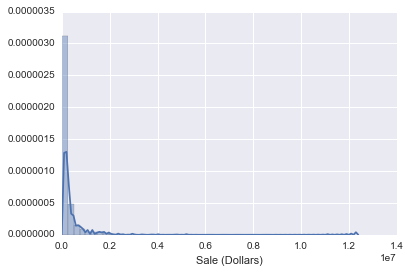

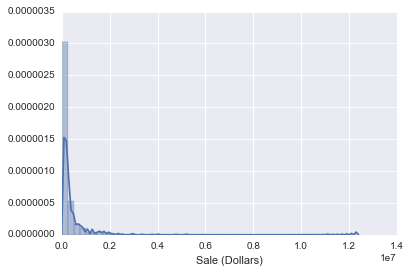

In [12]:
sns.distplot(a = data_grouped_by_store['Sale (Dollars)'])
plt.xlim(xmin = 0)
plt.show()

sns.distplot(a = data_for_open_stores.groupby(by = 'Store Number').sum()['Sale (Dollars)'])
plt.xlim(xmin = 0)
plt.show()

Why do so many stores have small sale numbers? Do they sell other items too, and therefore do not specialize in liquor?

In [13]:
# Top purchasers
data_grouped_by_store.sort_values(by = "Sale (Dollars)", ascending=False)[:5]

,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
Store Number,,,,,,,,,,
2633,1873872,25437462418,6271363,1492149440,22321350,297552.90,446632.44,744424,1.228265e+07,728464.86
4829,1759527,23867073523,5903128,1219043766,20830750,287765.54,431859.12,657032,1.108553e+07,634310.65
2512,933868,18741897194,4585412,988557914,16651900,201240.24,302111.72,356870,5.206166e+06,337589.99
3385,349695,6412183241,1573520,297869541,6521300,73548.16,110409.35,296426,4.759188e+06,330490.20
3420,297836,4036274646,1007084,173317729,4268800,48950.96,73476.88,226532,4.018415e+06,279281.50


In [14]:
# Lowest purchasers
data_grouped_by_store.sort_values(by = "Sale (Dollars)")[:5]

,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
Store Number,,,,,,,,,,
4567,1386,18640240,4498,616820,14175,139.82,210.29,118,827.13,75.24
5056,4680,62362640,13470,2622398,21250,307.93,462.04,158,973.58,48.83
4939,3311,44686480,10977,1661255,32150,398.89,598.43,110,1120.70,70.80
4486,450,15667480,3738,662875,10625,121.77,182.70,103,1232.38,98.23
4059,360,62338110,16611,2516767,58875,438.14,657.79,164,1813.33,177.11


Of the top-selling stores (from the unsampled list): 
* Store 2633 is Hyvee #3, a supermarket chain location. 
* Store 4829 is Central City 2, the second location for a chain of large liquor stores.

From the bottom-selling stores (from the unsampled list):
* Store 4486 is Kum & Go #608, a gas and convenience store.
* Store 5152 is Texas Street Market, a convenience store.
* Store 5056 is the Council Bluffs location of Sinclair, a gas station.

It seems I can sift out convenience stores by selecting stores that sell Scotch whisky, since they are less likely to sell and therefore more likely to be associated with dedicated liquor stores.

In [51]:
# Dropping Store 2633
data.drop(labels = data[data['Store Number'] == 2633].index, inplace = True)

# Adding the Scotch Filter
#mask = (data['Category'] == 1012200)
scotch_sellers = (data[data['Category'] == 1012200]['Store Number'])
filtered_data = data[data['Store Number'].isin(scotch_sellers)]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [59]:
print(len(data['Store Number'].unique()))
print(1 - len(data['Store Number'].unique()) / len(filtered_data['Store Number'].unique()))

1379
-0.33108108108108114


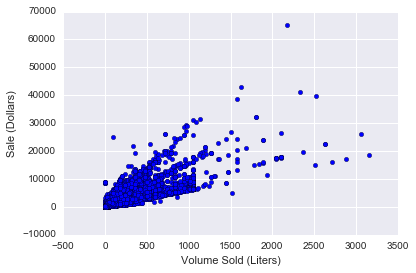

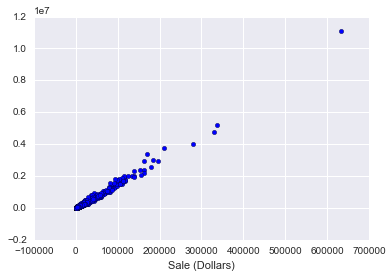

In [16]:
sns.plt.scatter(data = filtered_data, x = 'Volume Sold (Liters)', y = 'Sale (Dollars)')
plt.xlabel('Volume Sold (Liters)')
plt.ylabel('Sale (Dollars)')
sns.plt.show()
sns.plt.scatter(data = filtered_data.groupby(by = 'Store Number').sum(), x = 'Volume Sold (Liters)', y = 'Sale (Dollars)')
plt.xlabel('Volume Sold (Liters)')
plt.xlabel('Sale (Dollars)')
sns.plt.show()

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


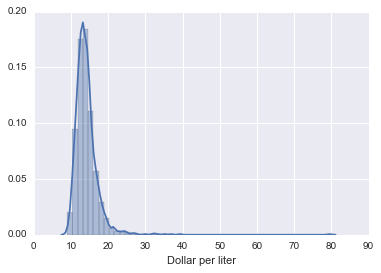

In [17]:
sns.distplot(a = data_grouped_by_store['Sale (Dollars)'] / data_grouped_by_store['Volume Sold (Liters)'])
plt.xlabel("Dollar per liter")
sns.plt.show()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

None of the data appears to be normally distributed, except for the sales data grouped by store.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [30]:
model_data = filtered_data[['City', 'Zip Code', 'Sales Q1 2015', 'State Bottle Retail', 'Bottles Sold', 'Sales Q1 2016']].groupby(by = 'City').sum()
model_data.dropna(inplace = True)

X = model_data.ix[:, model_data.columns != 'Sales Q1 2016']
y = model_data['Sales Q1 2016']

lm = linear_model.RidgeCV(normalize=True)
model = lm.fit(X, y)
predictions = model.predict(X)

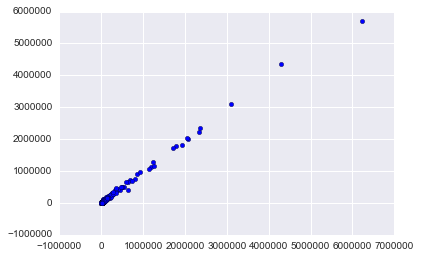

R2: 0.9948061065481725
MSE: 1737183221.4188766


In [44]:
sns.plt.scatter(x = y, y= predictions)
sns.plt.show()
print("R2: {}\nMSE: {}".format(metrics.r2_score(y, predictions), metrics.mean_squared_error(y, predictions)))

In [29]:
filtered_data[["City", "Sale (Dollars)"]].groupby(by = "City").mean().sort_values(by = "Sale (Dollars)", ascending = False)[0:5]

,Sale (Dollars)
City,
MOUNT VERNON,239.246261
WINDSOR HEIGHTS,228.065102
ORANGE CITY,212.730349
LAWLER,211.296421
MT VERNON,205.783873


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

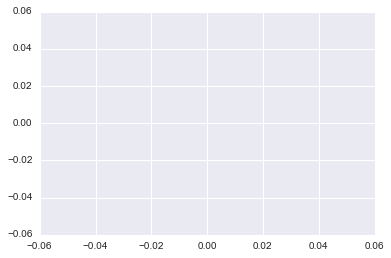

In [46]:
sns.plt.scatter(x = data["Sales Q1 2015"].dropna(), y = data['Sales Q1 2016'].dropna(inplac))
sns.plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.